In [1]:
from SpecificationMDP import *
from LearningAgents import *
import matplotlib
%matplotlib inline
#matplotlib.rcparams
matplotlib.rcParams['figure.figsize'] = [20,10]

In [2]:
MDP = CreateDinnerMDP()

@[DinnerPlate=0, SmallPlate=0, Bowl=0, Knife=0, Fork=0, Spoon=0, Mug=0, Glass=0, ]


In [3]:
def RecordLearningCurve(MDP, Learner, max_episodes = 10000, steps = 10, temp = 0.01, verbose = False):
    episodes = 0
    mean_rewards = []
    rewards = []
    std_rewards = []
    mean_episode_length = []
    ep = []
    
    for i in range(0,max_episodes,steps):
        
        if verbose:
            print(f'\r Training and evaluating with {i} episodes        ', end = '')
        
        episodes = episodes + steps
        ep.append(episodes)
        Learner.explore(episode_limit = steps, verbose = False)
        evaluator = ExplorerAgent(MDP, input_policy = Learner.create_learned_softmax_policy(temp))
        evaluator.explore(episode_limit = 50)
        r = [record[-1][3] for record in evaluator.episodic_record]
        l = [len(record) for record in evaluator.episodic_record]
        
        rewards.append(r)
        mean_rewards.append(np.mean(r))
        std_rewards.append(np.std(r))
        mean_episode_length.append(np.mean(l))
        
        #print(mean_rewards[-1])
        
        
    return mean_rewards, std_rewards, mean_episode_length, ep

 Training and evaluating with 9990 episodes        

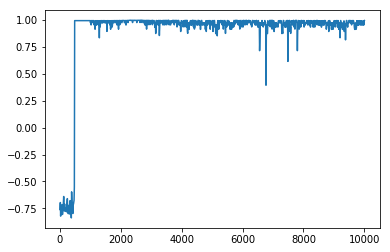

In [7]:
q_agent = QLearningAgent(MDP)
LCRecords = RecordLearningCurve(MDP, q_agent, max_episodes = 10000, steps = 10, temp = 0.01, verbose = True)
plt.plot(LCRecords[3], LCRecords[0])

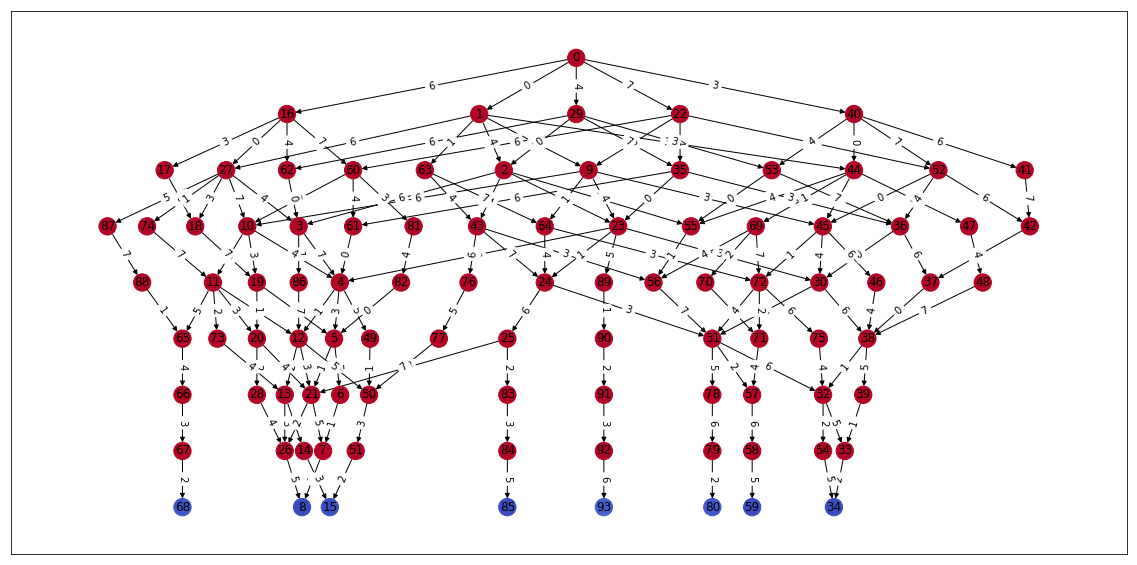

In [15]:
# stoch_eval = ExplorerAgent(MDP, input_policy = q_agent.create_learned_softmax_policy(0.01))
# stoch_eval.explore(episode_limit = 1000)
_ = stoch_eval.visualize_exploration()

In [4]:
q_agent = QLearningAgent(MDP, counterfactual_updates=True)
LCRecords = RecordLearningCurve(MDP, q_agent, max_episodes = 100, steps = 1, temp = 0.01, verbose = True)

 Training and evaluating with 99 episodes        

In [ ]:
MDP2 = CreateDinnerMDP(num_steps=2)
q_agent = QLearningAgent(MDP, counterfactual_updates=True)
LCRecords = RecordLearningCurve(MDP, q_agent, max_episodes = 100, steps = 1, temp = 0.01, verbose = False)

In [67]:
G = nx.DiGraph()
for n in stoch_eval.exploration_graph.nodes():
    node = stoch_eval.exploration_graph.nodes[n]
    G.add_node(node['name'])
for e in stoch_eval.exploration_graph.edges.data('action'):
    v1 = e[0]
    node1 = stoch_eval.exploration_graph.nodes[v1]
    v2 = e[1]
    node2 = stoch_eval.exploration_graph.nodes[v2]
    G.add_edge(node1['name'], node2['name'], label=e[2])

In [68]:
from networkx.drawing.nx_agraph import write_dot
write_dot(G, './graph.dot')